In [1]:
from finesse.plotting import plot_field
import numpy as np
import matplotlib.pyplot as plt
import finesse
finesse.configure(plotting=True)
from finesse.knm import Map
from finesse.utilities.maps import circular_aperture

In [2]:
#note to self: M1&M2input output have 1/4 inch displacement with these coordinates. M3 and M4 don't move and are these distances from origin.
#everything below is for NO DISPLACERS ANYWHERE

def cavity_params(longer=1,m1_displacer=0,m2_displacer=0,print_vars='no'):
    #x_coord = 10.6552 #in inches
    #y_coord = 1.1033 #in inches
    x_coord = 11.779 #in inches
    y_coord = 1.163 #in inches

    inch_to_m = .0254

    theta_static = np.arctan(y_coord/x_coord)

    m3_x = x_coord * inch_to_m * longer
    m3_y = y_coord * inch_to_m * longer

    m4_x = x_coord * inch_to_m * longer
    m4_y = y_coord * inch_to_m * longer

    #Displacers?
    M1_displacer = m1_displacer * inch_to_m #By default 0 is + quarter inch displacer for this mirror. 
    M2_displacer = m2_displacer * inch_to_m #By default 0 is + quarter inch displacer for this mirror.

    m1_x = x_coord * inch_to_m * longer + M1_displacer*np.cos(theta_static)
    m1_y = y_coord * inch_to_m * longer + M1_displacer*np.sin(theta_static)

    m2_x = x_coord * inch_to_m * longer + M2_displacer*np.cos(theta_static)
    m2_y = y_coord * inch_to_m * longer + M2_displacer*np.sin(theta_static)

    flat_distance12 = m1_x+m2_x
    diag_distance23 = np.sqrt((flat_distance12)**2+(m2_y+m3_y)**2)
    flat_distance34 = m3_x+m4_x
    diag_distance41 = np.sqrt((flat_distance34)**2+(m4_y+m1_y)**2)

    #Cavity Params
    L1 = flat_distance12
    L2 = diag_distance23
    L3 = flat_distance34
    L4 = diag_distance41

    if L1/L4>=1:
        cav_ang_1 = theta_static * 180/np.pi/2
        print(f'Warning:L1>L4, defaulting to theta_static')
    else:
        cav_ang_1 = np.arccos(L1/L4)/2*(180/np.pi)

    if L1/L2>=1:
        cav_ang_2 = theta_static * 180/np.pi/2
        print(f'Warning:L1>L2, defaulting to theta_static')
    else:
        cav_ang_2 = np.arccos(L1/L2)/2*(180/np.pi)

    if L3/L2>=1:
        cav_ang_3 = theta_static * 180/np.pi/2
        print(f'Warning:L3>L2, defaulting to theta_static')
    else:
        cav_ang_3 = np.arccos(L3/L2)/2*(180/np.pi)

    if L3/L4>=1:
        cav_ang_4 = theta_static * 180/np.pi/2
        print(f'Warning:L3>L4, defaulting to theta_static')
    else:
        cav_ang_4 = np.arccos(L3/L4)/2*(180/np.pi)

    if print_vars == 'yes':
        myVars = vars()
        for i in np.arange(4):
            print(f'L' + f'{i+1}')
            print(myVars[(f'L' + f'{i+1}')])
        for i in np.arange(4):
            print(f'cav_ang_' + f'{i+1}')
            print(myVars[(f'cav_ang_' + f'{i+1}')])
    else:
        pass
    return cav_ang_1,L1,cav_ang_2,L2,cav_ang_3,L3,cav_ang_4,L4


In [4]:
cav1 = cavity_params()
w0 = 600e-6
z0 = (.5 + cav1[1] + cav1[3])*-1
#w0 = 368.28e-6
#z0 = (.5 + cav1[1] + .13)*-1
print(z0)
print(cav1[3])
model1 = finesse.Model()
model1.parse(
    f"""
    
    lambda(1550e-9)

    l L0 P=1

    gauss g1 L0.p1.o w0={w0} z={z0} #negative is to right of laser
    ############################################################
    ##################CAVITY one################################
    ############################################################
    
    s s0 L0.p1 m1.p1 L=.5

    # Input mirror of cavity (flat)
    bs m1 R=(1-991e-6) T=991e-6 alpha={cav1[0]} Rc=-1.6

    # Space attaching m1->m2 
    s s1 m1.p3 m2.p1 L={cav1[1]}  #flat distance

    # Output mirror of cavity (flat)
    bs m2 R=0.999 T=0.001 alpha={cav1[2]}

    # Space attaching m2->m3 
    s s2 m2.p2 m3.p4 L={cav1[3]} #diag distance
   

    # m3
    bs m3 R=0.999 T=0.001 alpha={cav1[4]} 
    
    # Space attaching m3->m4 
    s s3 m3.p3 m4.p1 L={cav1[5]} #flat distance

    # m4
    bs m4 R=0.999 T=0.001 alpha={cav1[6]}
    
    ###########Space in between cavity##########################
    
    s s_s_1 m2.p3 m_s_1.p1 L=.2
    
    bs m_s_1 R=0.9999 T=0.0001 
    
    s s_s_2 m_s_1.p2 m_s_2.p1 L=.0762 #3 inches between center of mirrors when stacked

    bs m_s_2 R=0.999 T=0.001 
    
    # Space attaching m4->m1 
    s s4 m4.p2 m1.p4 L={cav1[7]} #diag distance
    
    cavity cavity1 source=m1.p3.o via=m1.p4.i
    
    pd refl m1.p2.o
    #pd circ m1.p4.i
    pd trns m2.p2.o
    
    xaxis(s2.L, lin,0.544178,.544178+1000e-9, 4000)
    
    """
)
print(model1.component_tree(model1.L0))

-1.6996559788506835
0.6012827788506835


C:\Users\torre\anaconda3\envs\finesse\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


○ L0
╰──○ m1
   ╰──○ m2
      ├──○ m3
      │  ╰──○ m4
      ╰──○ m_s_1
         ╰──○ m_s_2


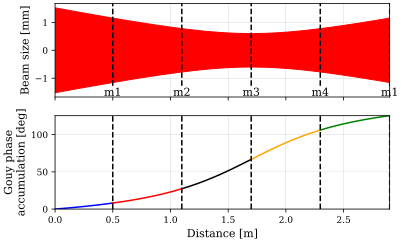

╒═════════╤═════════╤═══════════╤══════════╤══════════╤══════════════╤═══════════════════╤═════════════════╕
│ Name    │   z [m] │   w0 [mm] │   zr [m] │   w [mm] │      RoC [m] │   Acc. Gouy [deg] │ q               │
╞═════════╪═════════╪═══════════╪══════════╪══════════╪══════════════╪═══════════════════╪═════════════════╡
│ L0.p1.o │ 0       │       0.6 │  0.72966 │ 1.52097  │ -2.0129      │           0       │ -1.700 + 0.730j │
├─────────┼─────────┼───────────┼──────────┼──────────┼──────────────┼───────────────────┼─────────────────┤
│ m1.p1.i │ 0.5     │       0.6 │  0.72966 │ 1.15462  │ -1.64345     │           8.07521 │ -1.200 + 0.730j │
├─────────┼─────────┼───────────┼──────────┼──────────┼──────────────┼───────────────────┼─────────────────┤
│ m1.p3.o │ 0.5     │       0.6 │  0.72966 │ 1.15462  │ -1.64345     │           8.07521 │ -1.200 + 0.730j │
├─────────┼─────────┼───────────┼──────────┼──────────┼──────────────┼───────────────────┼─────────────────┤
│ m2.p1.i │ 1.09837

In [7]:
tsy1 = model1.propagate_beam(model1.L0.p1,model1.m1.p4) 
tsy1.plot();
print(tsy1)

waist_pos1 = (tsy1.waistpos("m2.p2.o")) 
waist1_ =(tsy1.w0("m2.p2.o")) 

data_dict = model1.detect_mismatches()

for key, value in data_dict.items():
    x_value = value.get('x', None)
    y_value = value.get('y', None)
    print(x_value,y_value)

In [8]:
####################################
#This takes a minute or two to run.#
####################################

def set_matrix_value(matrix, i, j, value):
    # Set the ith x jth element to the specific value
    matrix[i][j] = value


z0_array = np.arange(-2.5,0,.25)
w0_array = np.arange(200e-6,1000e-6,50e-6)
mm_array_x = np.zeros((len(w0_array),len(z0_array)))
mm_array_y = np.zeros((len(w0_array),len(z0_array)))


for j in np.arange(len(z0_array)):
    for i in np.arange(len(w0_array)):   
        w0 = w0_array[i]
        z0 = z0_array[j]
        model1 = finesse.Model()
        model1.parse(
            f"""

            lambda(1550e-9)

            l L0 P=1

            gauss g1 L0.p1.o w0={w0} z={z0} #negative is to right of laser
            ############################################################
            ##################CAVITY one################################
            ############################################################

            s s0 L0.p1 m1.p1 L=.5

            # Input mirror of cavity (flat)
            bs m1 R=0.9917 T=0.0083 alpha={cav1[0]} Rc=-1.6

            # Space attaching m1->m2 
            s s1 m1.p3 m2.p1 L={cav1[1]}  #flat distance

            # Output mirror of cavity (flat)
            bs m2 R=0.9917 T=0.0083 alpha={cav1[2]}

            # Space attaching m2->m3 
            s s2 m2.p2 m3.p4 L={cav1[3]} #diag distance

            # m3
            bs m3 R=0.9999 T=0.0001 alpha={cav1[4]} 

            # Space attaching m3->m4 
            s s3 m3.p3 m4.p1 L={cav1[5]} #flat distance

            # m4
            bs m4 R=0.999 T=0.001 alpha={cav1[6]}

            ###########Space in between cavity##########################

            s s_s_1 m2.p3 m_s_1.p1 L=.2

            bs m_s_1 R=0.9999 T=0.0001 

            s s_s_2 m_s_1.p2 m_s_2.p1 L=.0762 #3 inches between center of mirrors when stacked

            bs m_s_2 R=0.999 T=0.001 

            # Space attaching m4->m1 
            s s4 m4.p2 m1.p4 L={cav1[7]} #diag distance
            cavity cavity1 source=m1.p3.o via=m1.p4.i
            """
        )

        tsy1 = model1.propagate_beam(model1.L0.p1,model1.m1.p4) 

        data_dict = model1.detect_mismatches()

        for key, value in data_dict.items():
            x_value = value.get('x', None)
            y_value = value.get('y', None)
        set_matrix_value(mm_array_x, i, j, x_value)
        set_matrix_value(mm_array_y, i, j, y_value)


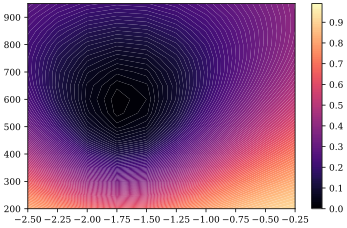

In [9]:
plt.contourf(z0_array,w0_array*1e6,(mm_array_x), np.arange(0,1,.01))
plt.colorbar()
plt.show()